<a href="https://colab.research.google.com/github/AVerma27/U-Net-Models/blob/main/U-Net%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining Required Functions 

In [ ]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Data Preparation

**Data Augmentation**

https://www.youtube.com/watch?v=ccdssX4rIh8



In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'/content/drive/MyDrive/membrane - UNet++/train','image','label',data_gen_args,save_to_dir = "/content/drive/MyDrive/membrane/train/aug/content/drive/MyDrive/membrane - UNet++/train/aug")

In [ ]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

# Model

## UNet++

In [ ]:
# tensorflow imports
from tensorflow import reduce_sum
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [ ]:
dropout_rate = 0.5

In [ ]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def Nest_Net(pretrained_weights = None,input_size = (256,256,1),  num_class=1, deep_supervision=False):
    
    nb_filter = [32,64,128,256,512]
    act = 'elu'
    
    bn_axis = 3
    img_input = Input(input_size, name = 'main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4])
    
    return model




    

## Losses

In [ ]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
from keras import backend as K 


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [ ]:

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
epoch = 100

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,"/content/drive/MyDrive/membrane - UNet++/train",'image','label',data_gen_args,save_to_dir = None)

modelnn = Nest_Net()
modelnn.summary()


adam = Adam(lr = 0.05, epsilon = 0.1)
#modelnn.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_loss])


'''testGene = testGenerator("/content/drive/MyDrive/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
#saveResult("/content/drive/MyDrive/membrane/test",results)'''

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv11_1 (Conv2D)              (None, 256, 256, 32  320         ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 dp11_1 (Dropout)               (None, 256, 256, 32  0           ['conv11_1[0][0]']               
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


'testGene = testGenerator("/content/drive/MyDrive/membrane/test")\nresults = model.predict_generator(testGene,30,verbose=1)\n#saveResult("/content/drive/MyDrive/membrane/test",results)'

In [ ]:
## Jacard coefficient
modelnn.compile(optimizer = adam, loss = [jacard_coef_loss], metrics = [jacard_coef,'accuracy'])

model_checkpoint = ModelCheckpoint('nest_net_membrane_jaccard.hdf5', monitor='loss',verbose=1, save_best_only=True)
history_jaccard = modelnn.fit(myGene,steps_per_epoch=20,epochs=epoch,callbacks=[model_checkpoint])


Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.1079 - jacard_coef: 0.6217 - accuracy: 0.6507
Epoch 1: loss improved from inf to 0.10788, saving model to nest_net_membrane_jaccard.hdf5
20/20 [==============================] - 19s 469ms/step - loss: 0.1079 - jacard_coef: 0.6217 - accuracy: 0.6507
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: -0.0493 - jacard_coef: 0.7786 - accuracy: 0.7786
Epoch 2: loss improved from 0.10788 to -0.04931, saving model to nest_net_membrane_jaccard.hdf5
20/20 [==============================] - 3s 143ms/step - loss: -0.0493 - jacard_coef: 0.7786 - accuracy: 0.7786
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: -0.0535 - jacard_coef: 0.7822 - accuracy: 0.7822
Epoch 3: loss improved from -0.04931 to -0.05351, saving model to nest_net_membrane_jaccard.hdf5
20/20 [==============================] - 3s 143ms/step - lo

In [ ]:
modelnn.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_loss,'accuracy'])

In [ ]:
history_dice = modelnn.fit(myGene,steps_per_epoch=20,epochs=epoch,callbacks=[model_checkpoint])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.1829 - dice_loss: 0.2054 - accuracy: 0.7260
Epoch 1: loss did not improve from -0.23541
20/20 [==============================] - 7s 139ms/step - loss: 2.1829 - dice_loss: 0.2054 - accuracy: 0.7260
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.4495 - dice_loss: 0.1891 - accuracy: 0.7565
Epoch 2: loss did not improve from -0.23541
20/20 [==============================] - 3s 138ms/step - loss: 1.4495 - dice_loss: 0.1891 - accuracy: 0.7565
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.3674 - dice_loss: 0.1908 - accuracy: 0.7782
Epoch 3: loss did not improve from -0.23541
20/20 [==============================] - 3s 127ms/step - loss: 1.3674 - dice_loss: 0.1908 - accuracy: 0.7782
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 1.3376 - dice_loss: 0.1942 - accuracy: 0.7804
Epoch 4: loss did not improve from -0.23541
20/20 [==============================

In [ ]:
testGene = testGenerator("/content/drive/MyDrive/membrane - UNet++/test")
print(testGene)

<generator object testGenerator at 0x7f0b5c0ac0d0>


In [ ]:
results = modelnn.predict_generator(testGene,30,verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


30/30 [==============================] - 9s 255ms/step


In [ ]:
#modelnn.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_loss,'accuracy'])

In [ ]:
import matplotlib.pylab as plt

"\n# summarize history for loss\nplt.subplot(1,2,2)\nplt.plot(history.history['loss'])\nplt.plot(history.history['dice_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'validation'], loc='upper left')"

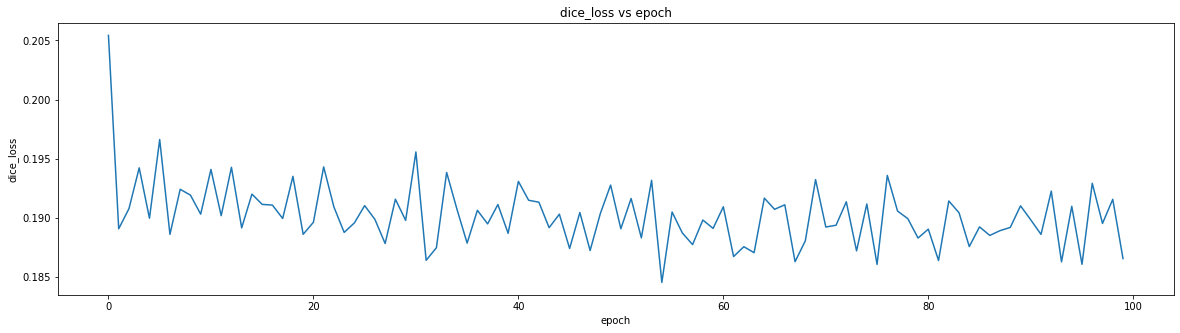

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_dice.history['dice_loss'])
plt.title('dice_loss vs epoch')
plt.ylabel('dice_loss')
plt.xlabel('epoch')






#plt.legend(['train', 'validation'], loc='upper left')
'''
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['dice_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')'''

Text(0.5, 0, 'epoch')

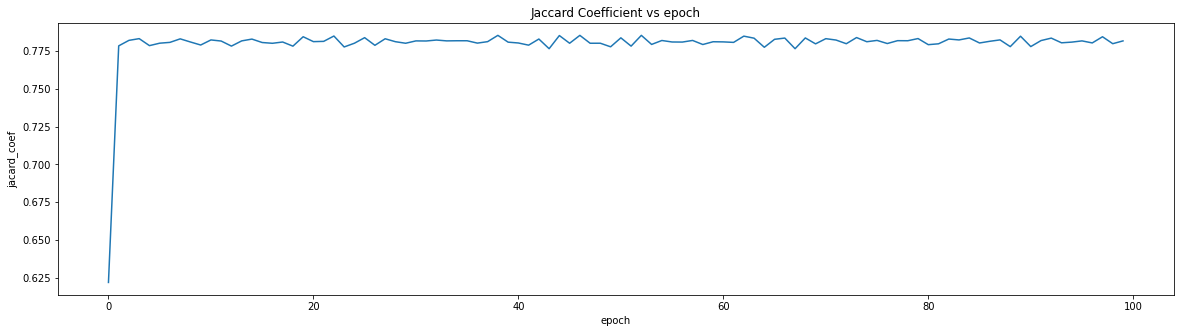

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_jaccard.history['jacard_coef'])
plt.title('Jaccard Coefficient vs epoch')
plt.ylabel('jacard_coef')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

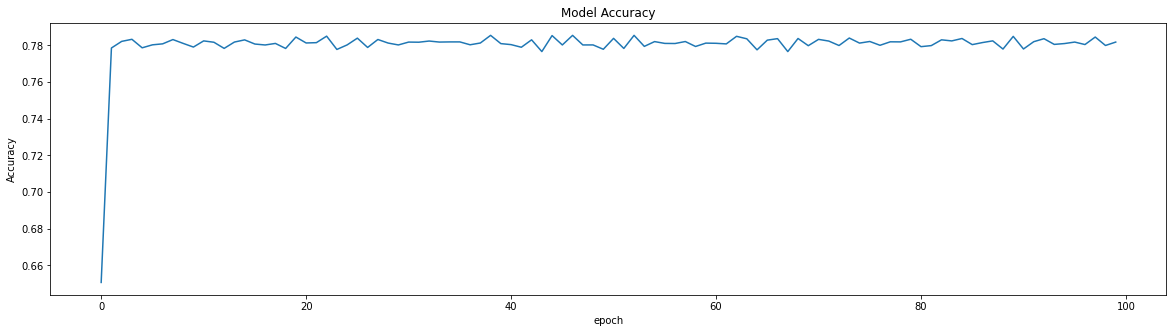

In [ ]:
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_jaccard.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
